# Training: BiRNN - Character Classifier
Training bidirectional RNN (recurrent neural network) for char classification

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random
import unidecode

sys.path.append('src')
from ocr.datahelpers import load_chars_data, corresponding_shuffle, char2idx
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot
from ocr.tfhelpers import create_cell


%matplotlib notebook
plt.rcParams['figure.figsize'] = (9.0, 5.0)

### Global Variables

In [3]:
LANG = 'en'

PAD = 0                            # Value for PADding images
EOS = 1                            # Value for End Of Sequence (not in use)

N_INPUT = 4096                     # Size of sequence input vector will depend on CNN
num_buckets = 10
CLAS = 83 if LANG =='cz' else 53   # Number of different outputs           

rnn_layers = 4
rnn_residual_layers = 2            # HAVE TO be smaller than encoder_layers
rnn_units = 256

learning_rate = 1e-4               # 1e-4
dropout = 0.4                      # Percentage of dopped out data
train_set = 0.8                    # Percentage of training data

TRAIN_STEPS = 500000
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 2000

save_loc = 'models/char-clas/' + LANG + '/Bi-RNN/model'
summaries_dir = 'logs/char-clas-RNN'

## Load Images and Lables

In [4]:
images, labels = load_chars_data(
    charloc='',
    wordloc='data/processed/breta/words_gaplines/',
    lang=LANG)

Loading chars...
Loading words...
 |████████████████████████████████████████| 100.0% 
-> Number of words: 5069
Loaded chars from words: 22883
 |████████████████████████████████████████| 100.0% 
-> Number of chars: 22883


In [4]:
# Extending dataset by inserting zero chars
def random_insert(lst):
    rand = random.randint(1, 3)
    inserts = random.sample(range(len(lst) + rand), rand)
    input = iter(lst)
    res = [0 if pos in inserts else next(input)
           for pos in range(len(lst) + rand)]
    return res

# Load Words
tmpWords = []
with open('data/dictionaries/' + LANG + '_50k.txt') as f:
    for line in f:
        tmpWords.append(unidecode.unidecode(line.split(" ")[0]))

length = len(tmpWords)
words = np.empty(4*length, dtype=object)
for i, word in enumerate(tmpWords):
    try:
        words[i] = [char2idx(c) for c in list(word)]
        words[i + length] = [char2idx(c) for c in list(word.title())]
        words[i + 2*length] = random_insert(words[i])
        words[i + 3*length] = random_insert(words[i + length])
    except KeyError:
        print(i)
        

del tmpWords

print("Number of words:", len(words))

Number of words: 199988


In [5]:
# Create images sequences corresponding to the words
class charFeed:
    def __init__(self, clas, letters):
        self.cnt = np.zeros(clas, dtype=np.int32)
        self.letters = letters
        
    def getChar(self, i):
        if not self.cnt[i] < len(self.letters[i]):
            random.shuffle(self.letters[i])
            self.cnt[i] = 0
            
        self.cnt[i] += 1
        return self.letters[i][self.cnt[i] - 1]
    
    def getLen(self, i):
        return len(self.letters[i])


# Separate images in such a way that there is each letter at leas once (in train and test set)
images, labels = corresponding_shuffle([images, labels])

letters = np.empty(CLAS, dtype=object)
for i in range(CLAS):
    letters[i] = []
for i in range(len(images)):
    letters[labels[i]].append(images[i])
    
trImages = []
teImages = []
trLabels = []
teLabels= []

feeder = charFeed(CLAS, letters)
for i in range(CLAS):
    for x in range(feeder.getLen(i)):
        if x % 12 == 0:
            teImages.append(feeder.getChar(i))
            teLabels.append(i)
        else:
            trImages.append(feeder.getChar(i))
            trLabels.append(i)
            
assert all((i in trLabels and i in teLabels) for i in range(CLAS))


np.random.shuffle(words)
div = int(train_set * len(words))
trainLabels = words[0:div]
testLabels = words[div:]
del words
        
trLetters = np.empty(CLAS, dtype=object)
teLetters = np.empty(CLAS, dtype=object)
for i in range(CLAS):
    trLetters[i] = []
    teLetters[i] = []
for i in range(len(trImages)):
    trLetters[trLabels[i]].append(trImages[i])
for i in range(len(teImages)):
    teLetters[teLabels[i]].append(teImages[i])
    
    
trFeeder = charFeed(CLAS, trLetters)
trainData = np.empty(len(trainLabels), dtype=object)
for i, word in enumerate(trainLabels):
    trainData[i] = [trFeeder.getChar(c) for c in word]
    
teFeeder = charFeed(CLAS, teLetters)
testData = np.empty(len(testLabels), dtype=object)
for i, word in enumerate(testLabels):
    testData[i] = [teFeeder.getChar(c) for c in word]
    
print("Training words: %g" % div)

Training words: 159990


## Dataset

In [6]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images_seq,
                 targets_seq,
                 num_buckets=5,
                 train=True):
        
        self.train = train
        length = [len(seq) for seq in images_seq]                

        # Create pandas dataFrame and sort it by images seq lenght (length)
        # in_length == out_length
        self.dataFrame = pd.DataFrame({'length': length,
                                       'images': images_seq,
                                       'targets': targets_seq
                                      }).sort_values('length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")


    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        max_length = max(res['length'])
        
        input_seq = np.zeros((batch_size, max_length, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['length'].values[i]] = img
        
        # Need to pad according to the maximum length output sequence
        targets = np.ones([batch_size, max_length], dtype=np.float32) * PAD
        for i, target in enumerate(targets):
            target[:res['length'].values[i]] = res['targets'].values[i]
        
        return input_seq, targets, res['length'].values


    def next_feed(self, size):
        """ Create feed directly for model training """
        (inputs_,
         targets_,
         length_) = self.next_batch(size)
        return {
            inputs: inputs_,            
            targets: targets_,
            length: length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [7]:
# Create iterators for data feeding
train_iterator = BucketDataIterator(trainData,
                                    trainLabels,
                                    num_buckets,
                                    train=True)
valid_iterator = BucketDataIterator(testData,
                                    testLabels,
                                    5,
                                    train=False)

Iterator created.
Iterator created.


# Classifier

## Inputs

In [8]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs shape (max_seq_length, batch_size, vec_size) - time major
inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='inputs')
length = tf.placeholder(shape=(None,),
                        dtype=tf.int32,
                        name='length')
# required for training, not required for testing and application
targets = tf.placeholder(shape=(None, None),
                         dtype=tf.int64,
                         name='targets')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## CNN

In [9]:
# Help functions for standard layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# 1. Layer - Convulation variables
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 8],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[8]), name='b_conv1')
# 3. Layer - Convulation variables
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 8, 16],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[16]), name='b_conv2')

def CNN(x):
    x = tf.reshape(x, [1, 64, 64, 1])
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name='h_conv1')
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Layer - Convulation
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
    # 4. Layer - Max Pool
    return max_pool_2x2(h_conv2, name='h_pool2')

# Input images CNN
inpts = tf.map_fn(
    lambda seq: tf.map_fn(
        lambda img:
            tf.reshape(
                CNN(img),
                [-1]),
        seq),
    inputs,
    dtype=tf.float32)

## Bi-RNN

In [10]:
# Cells
cell_fw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)
cell_bw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)

In [11]:
# Bidirectional RNN
bi_outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = cell_fw,
    cell_bw = cell_bw,
    inputs = inpts,
    sequence_length = length,
    dtype = tf.float32)

outputs = tf.concat(bi_outputs, -1, name='outputs')

# pred = tf.matmul(outputs, W)
# pred = tf.scan(lambda a, x: tf.matmul(x, W), outputs, infer_shape=False)
pred = tf.layers.dense(inputs=outputs,
                       units=CLAS,
                       name='pred')
prediction = tf.argmax(pred, axis=-1, name='prediction')

## Optimizer

In [12]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=pred, labels=targets),
                      name='loss')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,name='train_step')

# Evaluate model
correct_pred = tf.equal(prediction, targets)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

<IPython.core.display.Javascript object>


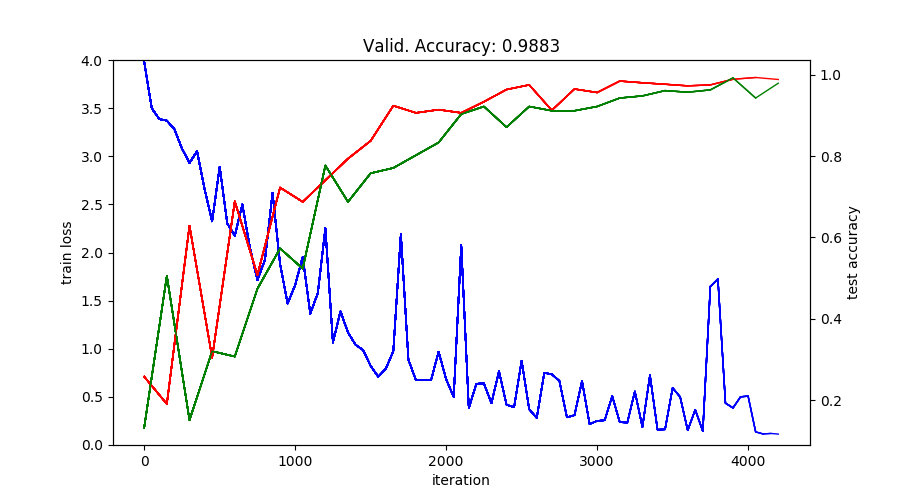

batch 0 - loss: 3.9829605
    expected  > [45 27 44 31 31]
    predicted > [28 20 36 20 20]

batch 2000 - loss: 0.29983974
    expected  > [27 42 46 38 51]
    predicted > [27 42 46 38 51]

batch 4000 - loss: 0.069107354
    expected  > [44 27  0 29 34]
    predicted > [44 27  0 29 34]

Training interrupted, model saved.
Training finished with accuracy: 0.982813


'models/char-clas/en/Bi-RNN/model_1'

In [13]:
sess = tf.InteractiveSession()
# TensorBoard
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()

train_writer = tf.summary.FileWriter(
    summaries_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(
    summaries_dir + '/test')


sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_valid = valid_iterator.next_feed(BATCH_SIZE)
                
            accTest, teSum = sess.run([accuracy, merged], feed_dict=fd_valid)
            accTrain, trSum = sess.run([accuracy, merged], feed_dict=fd)
                
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)
            test_writer.add_summary(teSum, i_batch)
            train_writer.add_summary(trSum, i_batch)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_loc)
        
        if i_batch % EPOCH == 0:
            fd_valid = valid_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_valid)))
            predict_, target_ = sess.run([prediction, targets], fd_valid)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                break
            print()

except KeyboardInterrupt:
    saver.save(sess, save_loc)
    print('Training interrupted, model saved.')


acc_val = accuracy.eval(valid_iterator.next_feed(2*BATCH_SIZE))
print("Training finished with accuracy:", acc_val)
saver.save(sess, save_loc)